In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sc_stats

# Text analysis
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SpanishStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('tokenizers/punkt/spanish.pickle')
nltk.download('stopwords')

import unicodedata

from wordcloud import WordCloud, STOPWORDS

import analysis_utils as aute

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading tokenizers/punkt/spanish.pickle: Package
[nltk_data]     'tokenizers/punkt/spanish.pickle' not found in index
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
tokenize_spanish = nltk.data.load('tokenizers/punkt/spanish.pickle')
spanish_stemmer = SpanishStemmer()
spanish_stopwords_th = stopwords.words('spanish')

In [3]:
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [4]:
all_df_list = []
for conv in os.listdir("Conversations/"):
    excel_name = [file for file in os.listdir("Conversations/" + conv) if ".xlsx" in file][0]
    df_x = pd.read_excel("Conversations/" + conv + "/" + excel_name)
    if df_x.shape[0] > 2:
        all_df_list.append(df_x)
            
print("Number of conversations:", len(all_df_list))

Number of conversations: 35


In [5]:
def clean_text(text, subject_name, 
               tokenize_spanish=tokenize_spanish, 
               spanish_stopwords_th=spanish_stopwords_th, 
               spanish_stemmer=spanish_stemmer, 
               use_stemmer=True):
    
    text = text.lower()
    text = text.replace('?', "").replace('¿', "").replace('!', "").replace('¡', "")
    if subject_name:
        text = text.replace(subject_name, "")
    text = strip_accents(text)
    
    text_token_list = []
    if use_stemmer:
        for word in text.split():
            token_text = tokenize_spanish.tokenize(word)
            if len(token_text) > 0 and word not in spanish_stopwords_th:
                text_token_list.append(spanish_stemmer.stem(token_text[0]))
    else:
        text_token_list.append(text)
            
    text = " ".join(text_token_list)
    
    return text

In [6]:
save_res_list = []
for i_df_x, df_x in enumerate(all_df_list):
    
    subject_name = df_x["SubjectId"].iloc[0]
    
    # ###############
    # ### General ###
    # ###############
    num_conv = df_x.shape[0] // 2
    
    text = ". ".join(df_x["SpanishMessage"].values)
    whole_text = clean_text(text, subject_name)
    
    num_words = len(whole_text.split(" "))
    conv_time_s = df_x["UnixTimestampInit"].values[-1] - df_x["UnixTimestampEnd"].values[0]
    # freq_conv_s = np.mean(df_x["unixtimestamp"].values[1:] - df_x["unixtimestamp"].values[:-1])
    
    time_answer_list, time_bot_answer_list, time_pers_answer_list = [], [], []
    for i in range(df_x.shape[0]-1):
        if df_x["Source"].iloc[i] == "Person":
            delta_t = df_x["UnixTimestampInit"].iloc[i+1] - df_x["UnixTimestampEnd"].iloc[i]
            time_bot_answer_list.append(delta_t)
        else:
            delta_t = df_x["UnixTimestampInit"].iloc[i+1] - df_x["UnixTimestampEnd"].iloc[i]
            time_pers_answer_list.append(delta_t)

        delta_t = df_x["UnixTimestampInit"].iloc[i+1] - df_x["UnixTimestampEnd"].iloc[i]
        time_answer_list.append(delta_t)
    
    # ###########
    # ### Bot ###
    # ###########
    df_bot = df_x[df_x["Source"] == "Bot"]
    
    text = ". ".join(df_bot["SpanishMessage"].values)
    bot_text = clean_text(text, subject_name)

    num_words_bot = len(bot_text.split(" "))
    
    # ##############
    # ### Person ###
    # ##############
    df_person = df_x[df_x["Source"] == "Person"]
    
    text = ". ".join(df_person["SpanishMessage"].values)
    person_text = clean_text(text, subject_name)
    
    num_words_person = len(person_text.split(" "))
    
    save_res_list.append({
        # General
        "SubjectId": df_x["SubjectId"].iloc[0],
        "FirstDate": df_x["UnixTimestampInit"].iloc[0],
        "LastDate": df_x["UnixTimestampEnd"].iloc[-1],
        "ConvTime_s": conv_time_s,
        # "FreqTime_s": freq_conv_s,
        "NumConv": num_conv,
        "NumSamples": df_x.shape[0],
        "AllText": whole_text,
        "OriginalAllText": ". ".join(df_x["SpanishMessage"].values),
        "Numwords": num_words,
        "TimeAnsAll": np.mean(time_answer_list),
        # ### Bot ###
        "BotText": bot_text,
        "OriginalBotText": ". ".join(df_bot["SpanishMessage"].values),
        "NumWordsBot": num_words_bot,
        "TimeAnsBot": np.mean(time_bot_answer_list),
        # ### Person ###
        "PersonText": person_text,
        "OriginalPersonText": ". ".join(df_person["SpanishMessage"].values),
        "NumWordsPerson": num_words_person,
        "TimeAnsPerson": np.mean(time_pers_answer_list),
    })
    
df_save = pd.DataFrame(save_res_list)
df_save.head(5)

,SubjectId,FirstDate,LastDate,ConvTime_s,NumConv,NumSamples,AllText,OriginalAllText,Numwords,TimeAnsAll,BotText,OriginalBotText,NumWordsBot,TimeAnsBot,PersonText,OriginalPersonText,NumWordsPerson,TimeAnsPerson
0,Ana,1.658937e+09,1.658937e+09,196.524779,13,26,llamas. llamas. hol nombr ana. hol nombr ana. ...,Como te llamas?. Como te llamas?. hola mi nomb...,53,3.951595,llamas. hol nombr ana. habl contigo. piens mue...,Como te llamas?. hola mi nombre es Ana. estoy ...,26,1.751842,llamas. hol nombr ana. habl contigo. piens mue...,Como te llamas?. hola mi nombre es Ana. estoy ...,26,6.334660
1,jose1,1.655144e+09,1.655144e+09,215.447323,12,24,llamas. nombr sus gradu universidad. buen trab...,Como te llamas?. Mi nombre es Susan y soy grad...,119,2.958246,nombr sus gradu universidad. buen trabajo.. ho...,Mi nombre es Susan y soy graduada de la univer...,68,0.254713,"llamas. hol susan, tal . alegr susan. dedic . ...","Como te llamas?. Hola susan, que tal todo ?. m...",50,5.907556
2,Jose3,1.656316e+09,1.656316e+09,360.716015,17,34,llamas. nombr sus gradu universitario.teng bue...,Como te llamas?. Mi nombre es Susan y soy un g...,178,3.031441,nombr sus gradu universitario.teng buen trabaj...,Mi nombre es Susan y soy un graduado universit...,95,0.822790,llamas. alegr mucho. tambi buen trabaj . cient...,Como te llamas?. Me alegro mucho. Yo también t...,82,5.378132
3,jOSEID10,1.658677e+09,1.658677e+09,22.820666,3,6,llamas. llamas. bien tal cuentas. bien tal cue...,Como te llamas?. Como te llamas?. yo estoy muy...,17,1.983749,llamas. bien tal cuentas. much graci llam guap,Como te llamas?. yo estoy muy bien y tú qué ta...,8,0.852903,llamas. bien tal cuentas. much graci llam guap,Como te llamas?. yo estoy muy bien y tú qué ta...,8,3.680018
4,Joseid10,1.658677e+09,1.658678e+09,117.104444,10,20,llamas. llamas. hol encant volv conocerte. hol...,Como te llamas?. Como te llamas?. hola yo lo e...,65,2.441242,llamas. hol encant volv conocerte. plac mio en...,Como te llamas?. hola yo lo encantado de volve...,32,0.917468,llamas. hol encant volv conocerte. plac mio en...,Como te llamas?. hola yo lo encantado de volve...,32,4.134324


Correlation value 0.9279911361017918
P-value ***
Coefficients: 
 [10.61298569] 
Intercept: 
 -12.636503067484654
R-square: 0.86


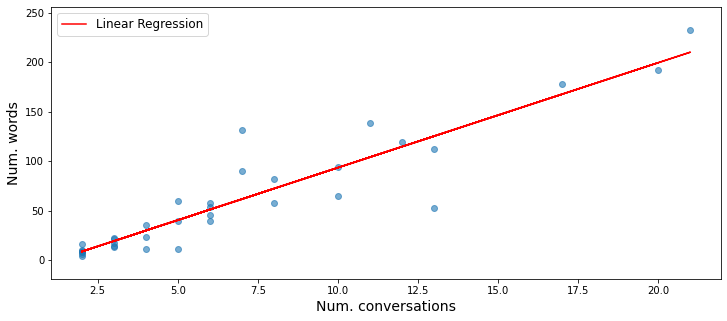

Correlation value 0.8921274195173495
P-value ***
Coefficients: 
 [0.48122222] 
Intercept: 
 4.4407006116324155
R-square: 0.80


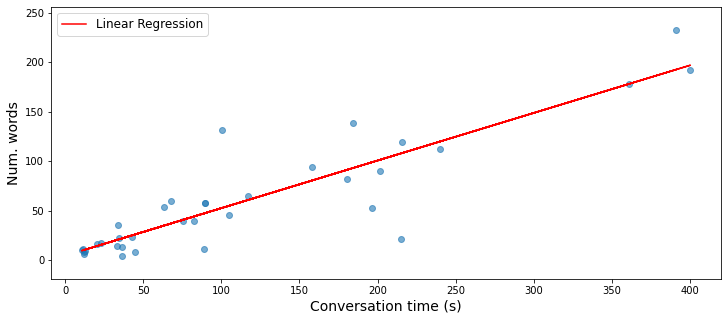

In [7]:
aute.make_scatter_plot(df=df_save, 
                       x_feat="NumConv", x_name="Num. conversations", 
                       y_feat="Numwords", y_name="Num. words", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="ConvTime_s", x_name="Conversation time (s)", 
                       y_feat="Numwords", y_name="Num. words", 
                       lr_mode=True)

P-value 0.7003951920361005 string p value -


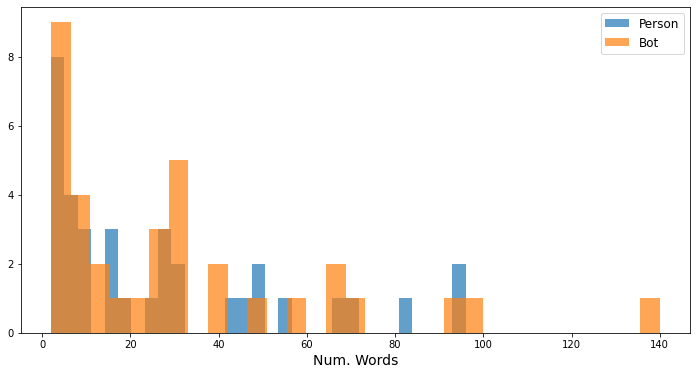


Mean answer time (s) 3.73097 +/- 6.18726
Mean answer time person (s) 7.36898 +/- 15.62315
Mean answer time bot (s) 1.12878 +/- 1.09563

P-value 0.0231613871044842 string p value *


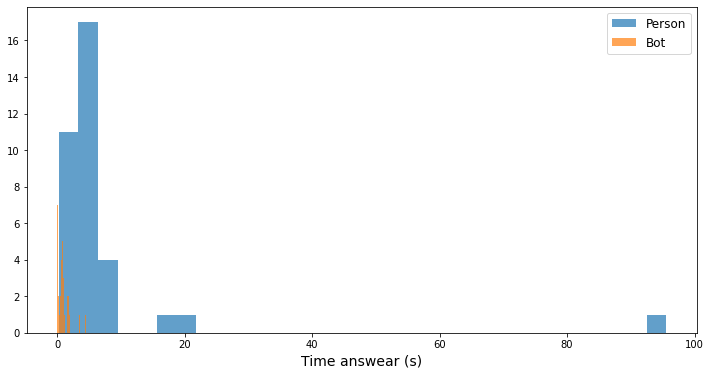

In [8]:
_, p = sc_stats.f_oneway(df_save["NumWordsPerson"].values, df_save["NumWordsBot"].values)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(12, 6))

plt.hist(df_save["NumWordsPerson"].values, bins=31, alpha=0.7, label="Person")
plt.hist(df_save["NumWordsBot"].values, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Num. Words", fontsize=14)
plt.legend(fontsize=12)

plt.show()

print()
print("Mean answer time (s)", np.round(np.mean(df_save["TimeAnsAll"].values),5), 
      "+/-", np.round(np.std(df_save["TimeAnsAll"].values),5) )
print("Mean answer time person (s)", np.round(np.mean(df_save["TimeAnsPerson"].values),5), 
      "+/-", np.round(np.std(df_save["TimeAnsPerson"].values),5) )
print("Mean answer time bot (s)", np.round(np.mean(df_save["TimeAnsBot"].values),5), 
      "+/-", np.round(np.std(df_save["TimeAnsBot"].values),5) )
print()
_, p = sc_stats.f_oneway(df_save["TimeAnsPerson"].values, df_save["TimeAnsBot"].values)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(12, 6))

plt.hist(df_save["TimeAnsPerson"].values, bins=31, alpha=0.7, label="Person")
plt.hist(df_save["TimeAnsBot"].values, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Time answear (s)", fontsize=14)
plt.legend(fontsize=12)

plt.show()

### Crude Text 

#### Token size analysis

In [9]:
openai_token_per_word = 100 / 75 # 100 tokens/75 words

In [10]:
df_save["OriginalPersonText"].tolist()[3].split(".")

['Como te llamas?',
 ' yo estoy muy bien y tú qué tal todo qué me cuentas',
 ' muchas gracias por llamarme guapo tú cómo estás']

In [11]:
def obtain_word_analysis(data, target):
    result_list = []
    for text in data[target].tolist():
        original_text_clean = clean_text(text, subject_name=None, use_stemmer=False)
        sentence_list = []
        for sentence in original_text_clean.split(". "):
            if len(sentence) > 1:
                sentence_list.append(sentence)

        len_list = [len(sent.split()) for sent in sentence_list]
        result_list.append({
            "mean": np.mean(len_list),
            "median": np.median(len_list),
            "std": np.std(len_list),
            "num_words_in_sentence": len_list
        })

    return pd.DataFrame(result_list)

Mean Number of words for BOT by sentence = 8.6398 +/- 5.0279 ; Median = 8.0 ; Min. =  1 ; Max. =  26
Mean Number of words for Person by sentence = 7.7471 +/- 5.0239 ; Median = 7.0 ; Min. =  1 ; Max. =  26


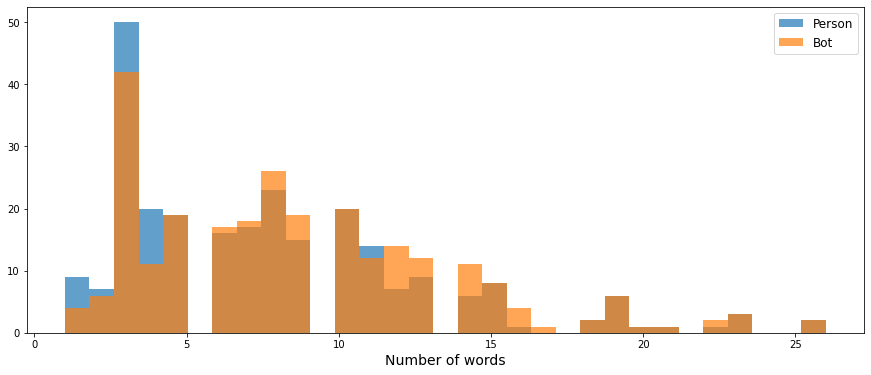

In [12]:
df_bot_result = obtain_word_analysis(df_save, "OriginalBotText")

bot_word_number = []
for my_list in df_bot_result["num_words_in_sentence"].tolist():
    bot_word_number += my_list
    
aute.stat_print(bot_word_number, "Number of words for BOT by sentence")

df_person_result = obtain_word_analysis(df_save, "OriginalPersonText")

person_word_number = []
for my_list in df_person_result["num_words_in_sentence"].tolist():
    person_word_number += my_list

aute.stat_print(person_word_number, "Number of words for Person by sentence")

plt.figure(figsize=(15, 6))

plt.hist(person_word_number, bins=31, alpha=0.7, label="Person")
plt.hist(bot_word_number, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Number of words", fontsize=14)
plt.legend(fontsize=12)

plt.show()

Mean Number of words for ALL by sentence = 8.1969 +/- 5.0457 ; Median = 8.0 ; Min. =  1 ; Max. =  26


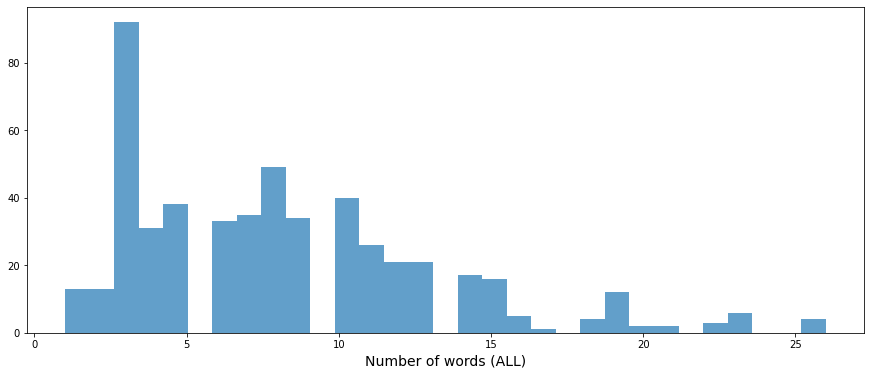

In [13]:
df_all_result = obtain_word_analysis(df_save, "OriginalAllText")

all_word_number = []
for my_list in df_all_result["num_words_in_sentence"].tolist():
    all_word_number += my_list

aute.stat_print(all_word_number, "Number of words for ALL by sentence")

plt.figure(figsize=(15, 6))

plt.hist(all_word_number, bins=31, alpha=0.7, label="All")
plt.xlabel("Number of words (ALL)", fontsize=14)

plt.show()

In [14]:
words_generated = 15

print("Number of tokens needed = ", words_generated * openai_token_per_word, "for a sentence of ", words_generated, "words")

price_per_token = 0.06 / 1000
dolar_to_euro = 1

print("Cost per sentence", words_generated * openai_token_per_word * price_per_token * dolar_to_euro, "euros")

Number of tokens needed =  20.0 for a sentence of  15 words
Cost per sentence 0.0012 euros


In [15]:
cost_list = []
for my_list in df_bot_result["num_words_in_sentence"].tolist():
    price_euros = np.sum(my_list) * openai_token_per_word * price_per_token * dolar_to_euro
    number_sentences = len(my_list)
    
    cost_list.append({
        "price_euros": price_euros,
        "number_sentences": number_sentences
    })
    
df_cost = pd.DataFrame(cost_list)

Correlation value 0.9472879698227379
P-value ***
Coefficients: 
 [0.00068456] 
Intercept: 
 4.9415543607291695e-05
R-square: 0.90


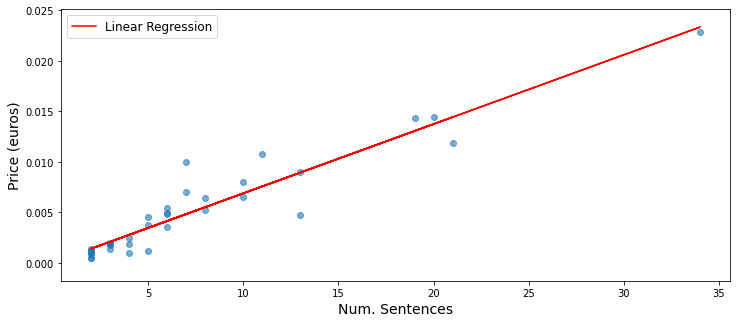

In [16]:
aute.make_scatter_plot(df=df_cost, 
                       x_feat="number_sentences", x_name="Num. Sentences", 
                       y_feat="price_euros", y_name="Price (euros)", 
                       lr_mode=True)

In [17]:
number_of_sentences = 100
words_generated = 40
print("Cost per conversation", 
      number_of_sentences * words_generated * openai_token_per_word * price_per_token * dolar_to_euro, 
      "euros")

Cost per conversation 0.31999999999999995 euros


In [18]:
number_of_sentences = 100
words_generated = 350
print("Tokens needed", words_generated * openai_token_per_word)
print("Tokens needed in total", words_generated * openai_token_per_word * number_of_sentences)
print("Cost per conversation", 
      number_of_sentences * words_generated * openai_token_per_word * price_per_token * dolar_to_euro, 
      "euros")

Tokens needed 466.66666666666663
Tokens needed in total 46666.666666666664
Cost per conversation 2.8 euros


## WordCloud analysis

- Falta tokenizar las palabras, eliminar acentos y etc.

- Estaria bien establecer un protocolo para eliminar el nombre del sujeto.

- Estudiar el número y cuales son las stopwords localizadas en el Bot y en la persona. Ver si estas stopwords son las mismas para ambos o distintas, etc. Posiblemente el sujeto utilice más stopwords que el sujeto o quizá no. 

### Whole text

In [19]:
whole_text = " ".join(df_save["AllText"]).replace(".", " ").replace(",", " ").lower()

all_words_list = [word for word in whole_text.split() if word not in spanish_stopwords_th]
uniq_words_list = list(set(all_words_list))
freq_words_appear = [
    {"Word": word, "Times": np.sum(np.array(all_words_list)==word)} for word in uniq_words_list
]
df_freq_all_words = pd.DataFrame(freq_words_appear).sort_values("Times", ascending=False).reset_index(drop=True)
df_freq_all_words.head(15)

,Word,Times
0,si,80
1,bien,78
2,llamas,72
3,pues,66
4,hol,60
5,verd,46
6,mari,45
7,tal,43
8,gust,41
9,buen,36


In [20]:
print("Number of different words", df_freq_all_words.shape[0])
print("Mean frequency", np.round(np.mean(df_freq_all_words["Times"]), 5), 
      "+/-", np.round(np.std(df_freq_all_words["Times"]), 5), 
      "Max", np.max(df_freq_all_words["Times"]), 
      "Min", np.min(df_freq_all_words["Times"]) )

Number of different words 435
Mean frequency 4.54253 +/- 9.32454 Max 80 Min 1


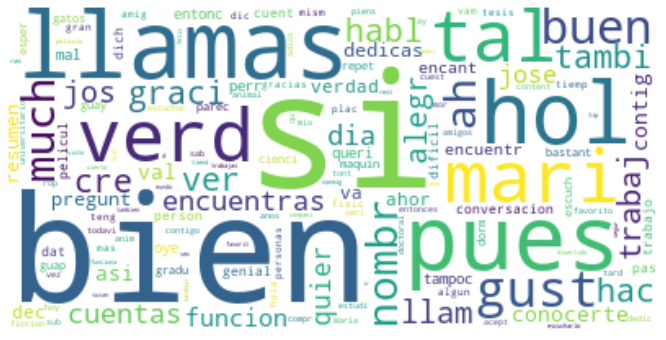

In [21]:
plt.figure(figsize=(15, 6))

all_wordcloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(all_words_list))

plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Bot analysis

In [22]:
whole_bot_text = " ".join(df_save["BotText"]).replace(".", " ").replace(",", " ").lower()

all_bot_words_list = [word for word in whole_bot_text.split() if word not in spanish_stopwords_th]
uniq_bot_words_list = list(set(all_bot_words_list))
freq_bot_words_appear = [
    {"Word": word, "Times": np.sum(np.array(all_bot_words_list)==word)} for word in uniq_bot_words_list
]
df_freq_bot_words = pd.DataFrame(freq_bot_words_appear).sort_values("Times", ascending=False).reset_index(drop=True)
df_freq_bot_words.head(15)

,Word,Times
0,bien,41
1,si,38
2,llamas,32
3,hol,29
4,pues,28
5,verd,23
6,mari,22
7,gust,21
8,buen,21
9,tal,20


In [23]:
print("Number of different words", df_freq_bot_words.shape[0])
print("Mean frequency", np.round(np.mean(df_freq_bot_words["Times"]), 5), 
      "+/-", np.round(np.std(df_freq_bot_words["Times"]), 5), 
      "Max", np.max(df_freq_bot_words["Times"]), 
      "Min", np.min(df_freq_bot_words["Times"]) )

Number of different words 381
Mean frequency 2.77953 +/- 4.7872 Max 41 Min 1


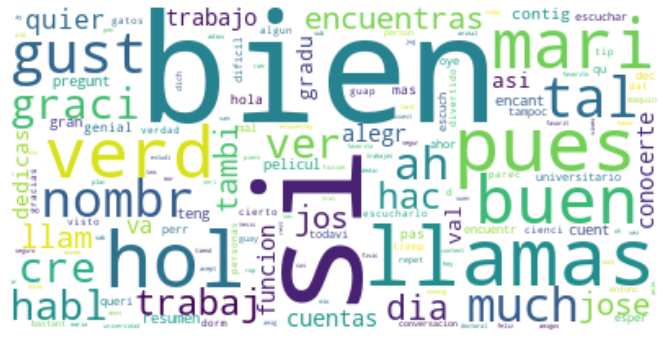

In [24]:
plt.figure(figsize=(15, 6))

all_wordcloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(all_bot_words_list))

plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Classifier

- Hacer un clasificador que sepa o pueda descubrir por las métricas obtenidas de la conversación si es un Bot o una persona. Lo interesante sería que NO.